# Libs

In [ ]:
import time
from functools import partial

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from bernstein_flow.activations import get_thetas_constrain_fn
from bernstein_flow.bijectors import BernsteinBijectorLinearExtrapolate
from bernstein_flow.distributions import BernsteinFlow
from bernstein_flow.util.visualization import plot_flow
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras as K
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
from tensorflow_probability.python.internal import (
    dtype_util,
    prefer_static,
    tensor_util,
)
from tqdm import tqdm, trange

# Functions

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [5]:
def get_nll(dist, pv, y):
    return lambda: -dist(pv).log_prob(y)

In [6]:
def plot_samples(dist, train_data, seed=1):
    N = train_data.shape[0]
    # Use the fitted distribution.
    start = time.time()
    samples = dist.sample(N, seed=seed)
    end = time.time()
    print(f"sampling took {end-start} seconds.")

    df1 = pd.DataFrame(columns=["x1", "x2"], data=train_data)
    df1 = df1.assign(source="data")

    df2 = pd.DataFrame(columns=["x1", "x2"], data=samples.numpy())
    df2 = df2.assign(source="model")

    df = df1.append(df2, ignore_index=True)

    # sns.jointplot(data=df, x='x1', y='x2', hue='source', kind='kde')
    g = sns.jointplot(
        data=df,
        x="x1",
        y="x2",
        hue="source",
        alpha=0.5,
        xlim=(data[..., 0].min() - 0.1, data[..., 0].max() + 0.1),
        ylim=(data[..., 1].min() - 0.1, data[..., 1].max() + 0.1),
    )
    g.plot_joint(sns.kdeplot)
    # g.plot_marginals(sns.rugplot, height=-.15)

In [7]:
def get_lr(opt, i):
    if callable(opt.learning_rate):
        return opt.learning_rate(i).numpy()
    else:
        return opt.learning_rate.numpy()

# Data

In [8]:
set_seed(1)
n_samples = 2000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
X, Y = noisy_moons
data = MinMaxScaler().fit_transform(X)

In [9]:
# Plot with labels
y_label = Y.astype(bool)
X_train, Y_train = data[..., 0], data[..., 1]
plt.scatter(X_train[y_label], Y_train[y_label], s=10, color="blue")
plt.scatter(X_train[y_label == False], Y_train[y_label == False], s=10, color="red")
plt.legend(["label: 1", "label: 0"])

# Compare Models

In [10]:
results = {}

In [11]:
dims = 2

## Klein 2019: Multivariate Conditional Transformation Models

The Multivariate Conditional Transformation Models proposed by Klein et al. 2019 is characterised by a set of marginal transformations $\tilde{h}_{j}\left(y_{j}\right), j=1, \ldots, J$, each applying to only a single component of the vector $\boldsymbol{Y}$, and by a lower triangular $(J \times J)$ matrix of transformation coefficients

$\boldsymbol{\Lambda}=\left(\begin{array}{ccccc}1 & & & & 0 \\ \lambda_{21} & 1 & & & \\ \lambda_{31} & \lambda_{32} & 1 & & \\ \vdots & \vdots & & \ddots & \\ \lambda_{J 1} & \lambda_{J 2} & \ldots & \lambda_{J, J-1} & 1\end{array}\right)$

Because the last coefficient, $\lambda_{jj}$ , cannot be separated from the marginal transformation function $\tilde{h}_{j}\left(y_{j}\right)$, we use the restriction $\lambda_{jj} = 1$. Thus, parameterisation of the transformation function $h$ finally reads

$$
h_j(y_1,\ldots,y_j) = \lambda_{j 1} \tilde{h}_{1}(y_1)+\ldots+\lambda_{j,j-1} \tilde{h}_{j-1}(y_{j-1}) + \tilde{h}_j(y_j)$$

the model-based density function for $Y$ is then defined as

$f_{\boldsymbol{Y}}(\boldsymbol{y})=\prod_{j=1}^{J} \phi_{0,1}\left(\lambda_{j 1} \tilde{h}_{1}\left(y_{1}\right)+\ldots+\lambda_{j, j-1} \tilde{h}_{j-1}\left(y_{j-1}\right)+\tilde{h}_{j}\left(y_{j}\right)\right) \frac{\partial \tilde{h}_{j}\left(y_{j}\right)}{\partial y_{j}}$

By extending the unconditional transformation function, we define the $J$ components of a multivariate conditional transformation function given covariates $x$:
    
$$
h_j(\mathbf{y}|\mathbf{x}) = \sum_{i=1}^{j-1}\lambda_{ji}(\mathbf{x})\tilde{h}_i(y_i|\mathbf{x}) + \tilde{h}_j(y_j|\mathbf{x})
$$

The MultivariateNormal distribution is a member of the [location-scale family](https://en.wikipedia.org/wiki/Location%E2%80%93scale_family), i.e., it can be constructed as,

```
X ~ MultivariateNormal(loc=0, scale=1)   # Identity scale, zero shift.
Y = scale @ X + loc
```

Hence, we can spit it into the larnable marginal transformation $\tilde h$ and a conditional scale term $\Lambda$:

$$
t(\mathbf{y}|\mathbf{x}) = \Lambda(\mathbf{x}) \cdot h(\mathbf{y}|\mathbf{x})
$$

In [17]:
def get_mctm_lambda(dims, M, thetas_constrain_fn):
    def lmbd(pv):
        bs = prefer_static.shape(pv)[:-1]
        shape = tf.concat((bs, [dims, M]), 0)

        thetas = thetas_constrain_fn(tf.reshape(pv[..., : M * dims], shape))
        scale_tril = tfp.bijectors.FillScaleTriL()(pv[..., M * dims :])

        mv_normal = tfd.MultivariateNormalTriL(loc=0, scale_tril=scale_tril)

        return tfd.TransformedDistribution(
            distribution=mv_normal,
            bijector=tfb.Invert(BernsteinBijectorLinearExtrapolate(thetas=thetas)),
        )

    return lmbd

In [18]:
def fit_mctm(data, M, dims, epochs, seed, learning_rate, **kwds):
    set_seed(seed)

    pv_shape = M * dims + np.sum(np.arange(dims + 1))
    pv = tf.Variable(tf.random.normal([pv_shape], dtype=tf.float32), trainable=True)

    thetas_constrain_fn = get_thetas_constrain_fn(**kwds)

    mctm = get_mctm_lambda(dims, M, thetas_constrain_fn)

    print("Number of Parameters:", tf.size(pv).numpy())

    opt = tf.optimizers.Adam(learning_rate)
    it = trange(epochs)
    # idx = np.arange(n_samples)
    for i in it:
        # np.random.shuffle(idx)
        # for batch in tqdm(data[idx].reshape((-1, 100, 2)), leave=False):
        nll = get_nll(mctm, pv, data)
        opt.minimize(nll, var_list=[pv])
        it.set_postfix(loss=nll().numpy().mean(), lr=get_lr(opt, i))

    return nll().numpy().mean(), mctm(pv)

In [19]:
nll, mctm = fit_mctm(
    data,
    M=50,
    dims=dims,
    epochs=400,
    seed=1,
    learning_rate=0.1,
    low=-3,
    high=3,
    smooth_bounds=True,
    allow_flexible_bounds=True,
    fn=tf.math.softplus,
    # eps=1e-04,
)
results["MCTM"] = nll

In [21]:
plot_samples(mctm, data, seed=1)

In [20]:
mctm.parameters

## Germain et al. 2015: MADE: Masked Autoencoderkerasr Distribution Estimation

### Abstract
Germain et al. [4] introduced a simple modification for autoencoder neural networks that masks the parameters process the inputs folowing autoregressive constraints.
Each input is reconstructed only from previous inputs in a given ordering.

### Masked Autoencoders

To satisfy the autoregressive property, output $\hat{x}_{d}$ must depend only on the preceding inputs $\mathbf{x}_{<d}$.
Hence there must be no computational path between output unit $\hat{x}_{d}$ and any of the input units $x_{d}, \ldots, x_{D}$.

In other words, for each of these paths, at least one connection in the neural Network must be 0.

A convenient way of zeroing connections is to elementwisemultiply each matrix by a binary mask matrix, whose entries that are set to 0 correspond to the connections we wish to remove. For a single hidden layer autoencoder, we write

$$
\begin{aligned}
\mathbf{h}(\mathbf{x}) &=\mathbf{g}\left(\mathbf{b}+\left(\mathbf{W} \odot \mathbf{M}^{\mathbf{W}}\right) \mathbf{x}\right) \\
\hat{\mathbf{x}} &=\operatorname{sigm}\left(\mathbf{c}+\left(\mathbf{V} \odot \mathbf{M}^{\mathbf{V}}\right) \mathbf{h}(\mathbf{x})\right)
\end{aligned}
$$

where $\mathbf{M}^{\mathbf{W}}$ and $\mathbf{M}^{\mathbf{V}}$ are the masks for $\mathbf{W}$ and $\mathbf{V}$ respectively. It is thus left to the masks $\mathbf{M}^{\mathbf{W}}$ and $\mathbf{M}^{\mathbf{V}}$ to satisfy the autoregressive property.

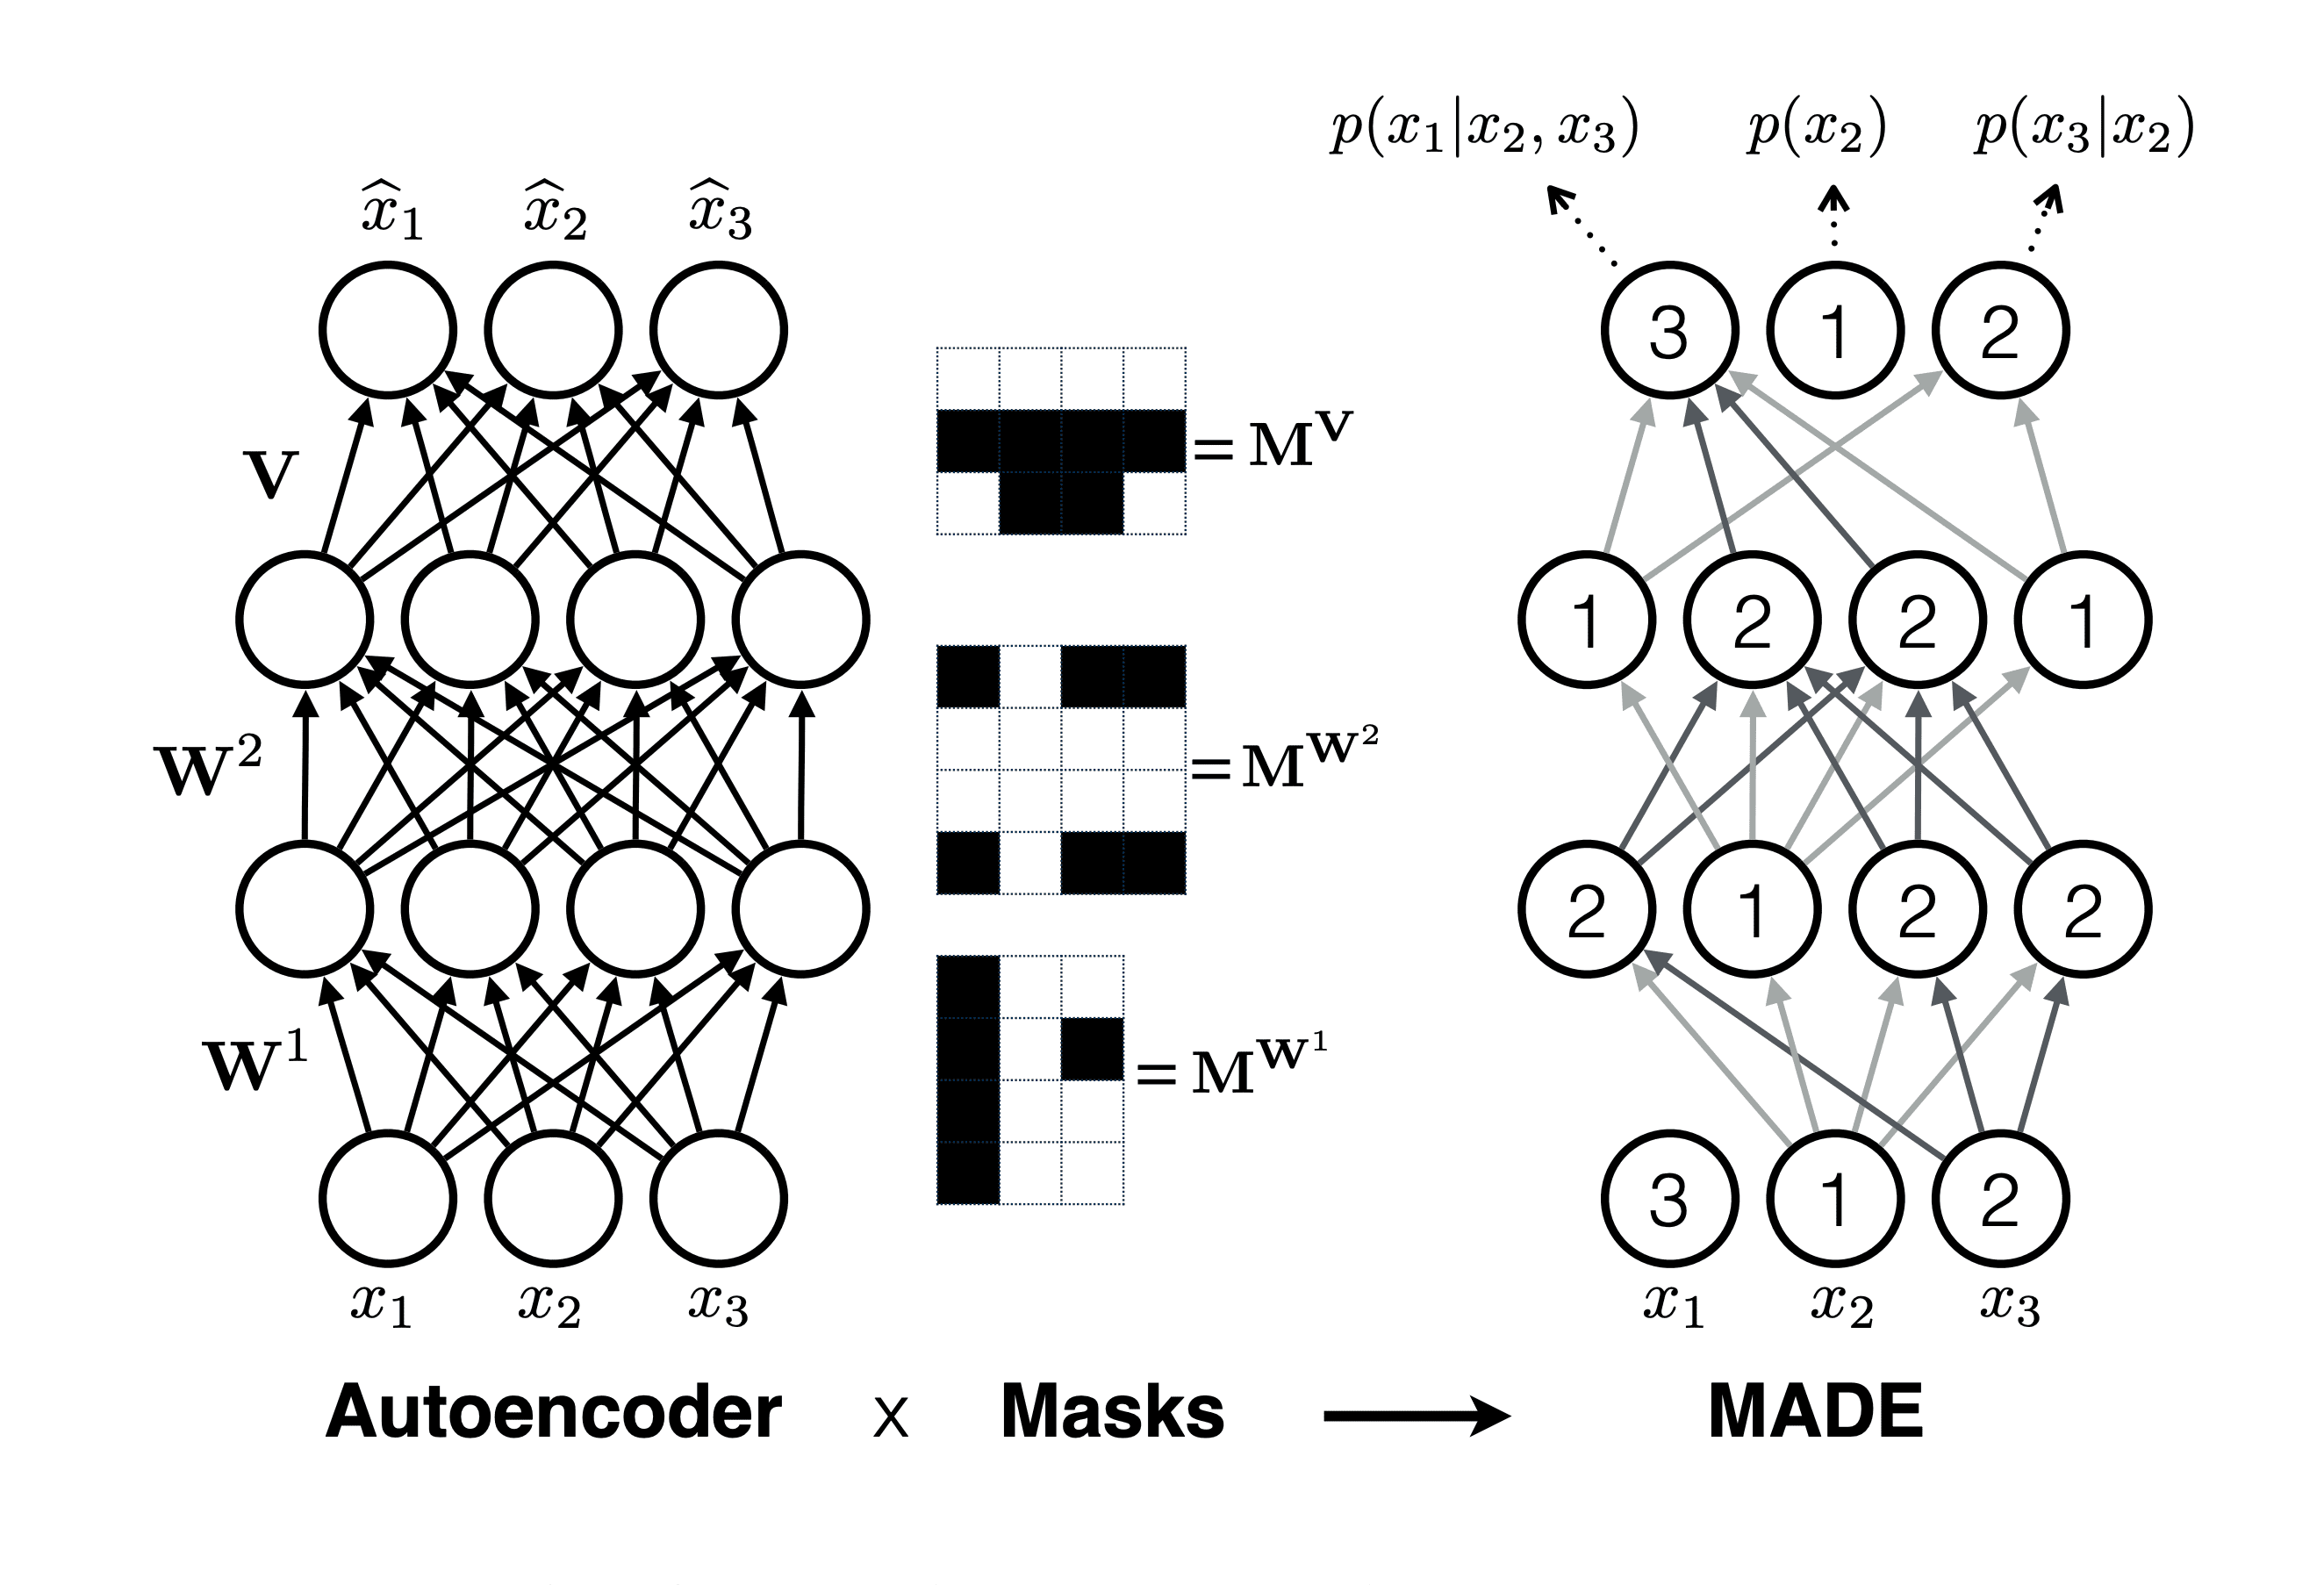

> Left: Conventional three hidden layer autoencoder.
Input in the bottom is passed through fully connected layers and
point-wise nonlinearities. In the final top layer, a reconstruction
specified as a probability distribution over inputs is produced.
As this distribution depends on the input itself, a standard au-
toencoder cannot predict or sample new data. Right: MADE.
The network has the same structure as the autoencoder, but a set
of connections is removed such that each input unit is only pre-
dicted from the previous ones, using multiplicative binary masks
($M^{W^1}$, $M^{W^1}$, $M^V$ ). In this example, the ordering of the input
is changed from 1,2,3 to 3,1,2. This change is explained in sec-
tion 4.2, but is not necessary for understanding the basic principle.
The numbers in the hidden units indicate the maximum number
of inputs on which the kth unit of layer l depends. The masks are
constructed based on these numbers (see Equations 12 and 13).
These masks ensure that MADE satisfies the autoregressive prop-
erty, allowing it to form a probabilistic model, in this example
$p(x) = p(x_2) p(x_3|x_2) p(x_1|x_2,x_3)$. Connections in light gray
correspond to paths that depend only on 1 input, while the dark
gray connections depend on 2 inputs.

### Constructing the Masks

To impose the autoregressive property we first assign each unit in the hidden layer an integer $m$ between 1 and $D-1$ inclusively. The $k^{\text {th }}$ hidden unit's number $m(k)$ gives the maximum number of input units to which it can be connected. We disallow $m(k)=D$ since this hidden unit would depend on all inputs and could not be used in modelling any of the conditionals $p\left(x_{d} \mid \mathbf{x}_{<d}\right)$. Similarly, we exclude $m(k)=0$, as it would create constant hidden units.

The constraints on the maximum number of inputs to each hidden unit are encoded in the matrix masking the connections between the input and hidden units:
$$
M_{k, d}^{\mathrm{W}}=1_{m(k) \geq d}= \begin{cases}1 & \text { if } m(k) \geq d \\ 0 & \text { otherwise }\end{cases}
$$
for $d \in\{1, \ldots, D\}$ and $k \in\{1, \ldots, K\}$. Overall, we need to encode the constraint that the $d^{\text {th }}$ output unit is only connected to $\mathbf{x}_{<d}$ (and thus not to $\mathbf{x}_{\geq d}$ ). Therefore the output weights can only connect the $d^{\text {th }}$ output to hidden units with $m(k)<d$, i.e. units that are connected to at most $d-1$ input units. These constraints are encoded in the output mask matrix:
$$
M_{d, k}^{\mathrm{V}}=1_{d>m(k)}= \begin{cases}1 & \text { if } d>m(k) \\ 0 & \text { otherwise }\end{cases}
$$
again for $d \in\{1, \ldots, D\}$ and $k \in\{1, \ldots, K\}$. **Notice that, from this rule, `no hidden units will be connected to the first output` unit $\hat{x}_{1}$, as desired.**

From these mask constructions, we can easily demonstrate that the corresponding masked autoencoder satisfies the autoregressive property. First, we note that, since the masks $\mathbf{M}^{\mathbf{V}}$ and $\mathbf{M}^{\mathbf{W}}$ represent the network's connectivity, their matrix product $\mathbf{M}^{\mathbf{V}, \mathbf{W}}=\mathbf{M}^{\mathbf{V}} \mathbf{M}^{\mathbf{W}}$ represents the connectivity between the input and the output layer.

Constructing the masks $M^{V}$ and $M^{W}$ only requires an
assignment of the $m(k)$ values to each hidden unit. One could imagine trying to
assign an (approximately) equal number of units to each legal value of $m(k)$.
In our experiments, we instead set $m(k)$ by sampling from a uniform discrete
distribution defined
on integers from $1$ to $D-1$, independently for each of the $K$ hidden units.

### TFP implementation of Made Network

[`tfb.masked_autoregressive`](https://github.com/tensorflow/probability/blob/e3d67c00ab491f4314a3d3e8c2cde19c8aa7490e/tensorflow_probability/python/bijectors/masked_autoregressive.py) contains a TF implemetations of MADE Network

its uses the function [`_make_dense_autoregressive_mask`](https://github.com/tensorflow/probability/blob/e3d67c00ab491f4314a3d3e8c2cde19c8aa7490e/tensorflow_probability/python/bijectors/masked_autoregressive.py#L1148) to generate the Masks.

## G. Papamakarios 2018: Masked Autoregressive Flow for Density Estimation

Papamakarios et al.  used MADE networks to build an autoregressive flow model by stacking multiple MADE layers, each modelling the random numbers of the next in the stack.
This leads to a type of normalizing flow called Masked Autoregressive Flow.
This type of flow is closely related to Inverse Autoregressive Flow and is a generalization of Real NVP. Masked Autoregressive Flow achieves state-of-the-art performance in a range of general-purpose density estimation tasks.

In [39]:
def fit_maf(
    data, dims, epochs, seed, learning_rate, hidden_units, layers, distribution
):
    set_seed(seed)

    opt = tf.optimizers.Adam(learning_rate)

    bijectors = []
    trainable_variables = []
    for _ in range(layers):
        made = tfb.AutoregressiveNetwork(
            params=dims, hidden_units=hidden_units, activation="relu"
        )
        made.build((dims,))
        trainable_variables += made.trainable_variables

        bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made))
        bijectors.append(tfb.Permute(permutation=[1, 0]))

    maf = tfd.TransformedDistribution(
        distribution=distribution,
        bijector=tfb.Chain(bijectors),
    )

    print("Number of Parameters:", sum(map(tf.size, trainable_variables)).numpy())
    it = trange(epochs)
    for i in it:
        nll = lambda: -maf.log_prob(data)
        opt.minimize(nll, var_list=trainable_variables)
        it.set_postfix(loss=nll().numpy().mean(), lr=get_lr(opt, i))

    return nll().numpy().mean(), maf

In [31]:
nll, maf = fit_maf(
    data,
    dims=dims,
    epochs=400,
    seed=1,
    learning_rate=0.005,
    hidden_units=[16, 16],
    layers=4,
    distribution=tfd.Sample(tfd.Normal(loc=0.0, scale=1.0), sample_shape=[2]),
)
results["MAF"] = nll

Number of Parameters: 1552


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:55<00:00,  7.22it/s, loss=-1.07, lr=0.005]


/tmp/ipykernel_473031/3433419466.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2, ignore_index=True)


sampling took 0.04866647720336914 seconds.


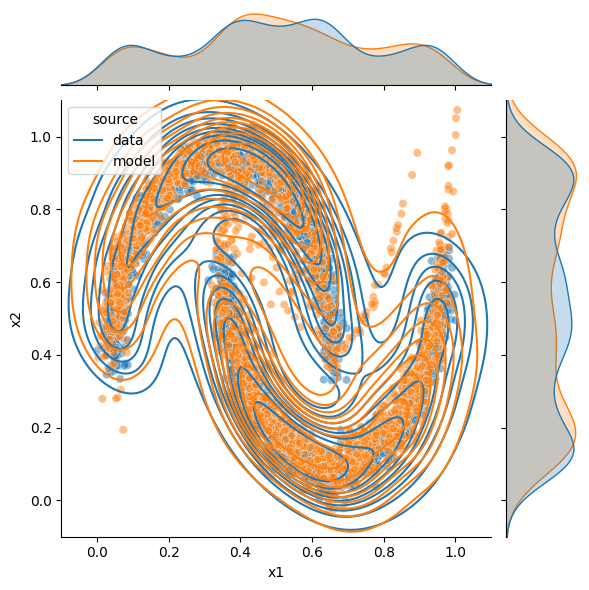

In [32]:
plot_samples(maf, data, seed=1)

## Kingma et al 2017: Improving Variational Inference with Inverse Autoregressive Flow

The framework of normalizing flows provides a general strategy for flexible vari-
ational inference of posteriors over latent variables. We propose a new type of
normalizing flow, inverse autoregressive flow (IAF), that, in contrast to earlier
published flows, scales well to high-dimensional latent spaces. The proposed flow
consists of a chain of invertible transformations, where each transformation is
based on an autoregressive neural network. In experiments, we show that IAF
significantly improves upon diagonal Gaussian approximate posteriors. In addition,
we demonstrate that a novel type of variational autoencoder, coupldistributionwith IAF, is
competitive with neural autoregressive models in terms of attained log-likelihood
on natural images, while allowing significantly faster synthesis.

By stacking multiple bijectors we increase expressivenes

In [33]:
def fit_iaf(
    data, dims, epochs, seed, learning_rate, hidden_units, layers, distribution
):
    set_seed(seed)

    opt = tf.optimizers.Adam(learning_rate)

    bijectors = []
    trainable_variables = []
    for _ in range(layers):
        made = tfb.AutoregressiveNetwork(
            params=dims, hidden_units=hidden_units, activation="relu"
        )
        made.build((dims,))
        trainable_variables += made.trainable_variables

        bijectors.append(
            tfb.Invert(  # Invert MAF
                tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)
            )
        )
        bijectors.append(tfb.Permute(permutation=[1, 0]))

    maf = tfd.TransformedDistribution(
        distribution=distribution,
        bijector=tfb.Chain(bijectors),
    )

    print("Number of Parameters:", sum(map(tf.size, trainable_variables)).numpy())
    it = trange(epochs)
    for i in it:
        nll = lambda: -maf.log_prob(data)
        opt.minimize(nll, var_list=trainable_variables)
        it.set_postfix(loss=nll().numpy().mean(), lr=get_lr(opt, i))

    return nll().numpy().mean(), maf

In [34]:
nll, iaf = fit_iaf(
    data,
    dims=dims,
    epochs=400,
    seed=1,
    learning_rate=0.005,
    hidden_units=[16, 16],
    layers=4,
    distribution=tfd.Sample(tfd.Normal(loc=0.0, scale=1.0), sample_shape=[2]),
)
results["IAF"] = nll

Number of Parameters: 1552


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:10<00:00,  5.66it/s, loss=-1.12, lr=0.005]


/tmp/ipykernel_473031/3433419466.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2, ignore_index=True)


sampling took 0.050397634506225586 seconds.


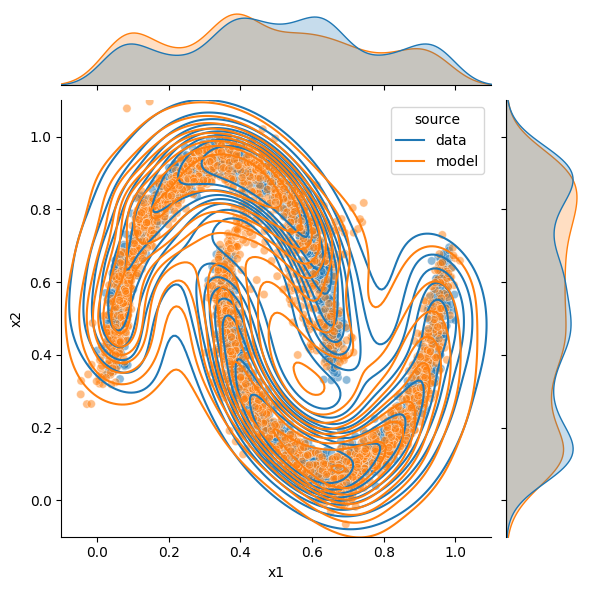

In [35]:
plot_samples(iaf, data, seed=1)

## Bernstein Normalizing Flows

https://github.com/tensorchiefs/bfvi/blob/main/R/multidimensional_script.R

The main idea of~\gls{NF} is to fit a parametric bijective conditional function $z=f(y|\theta(\mathbf{x}))$ that transforms between a possibly complex conditional target distribution $p_y(y|\mathbf{x})$ and a simple distribution $p_z(z)$, often $p_z(z)=N(0,1)$. The change of variable formula allows us to calculate the probability $p_y(y|\mathbf{x})$ from the simple probability $p_z(z)$ as follows:

\begin{equation}
  p_y(y|\mathbf{x}) = p_z\left(f(y)|\theta(\mathbf{x})\right) \left|\det\nabla{f}(y|\theta(\mathbf{x}))\right|
  \label{eq:prob}
\end{equation}

With the Jacobian determinant $\det\nabla{f(y|\theta(\mathbf{x}))}$ ensuring that the probability integrates to one after the transformation (hence the name normalizing flow).
Sampling from the learned \emph{data distribution} $p_y$ is then achieved by first sampling $z$ from the simple \emph{base distribution} $p_z$ and passing it through the \emph{inverse transformation} $f^{-1}(z|\theta(\mathbf{x}))$ to obtain $y$.
This leads to the two main properties the transformation functions must satisfy: i) $f$ must be \emph{invertible}, usually guaranteed by restricting the transformation function to be strictly monotone, and ii) both $f$ and $f^{-1}$ must be \emph{differentiable}.

The parameters $\theta$ of the bijective transformation functions $f$ can then be tuned by maximizing the likelihood $\mathcal{L}$ of the samples $y$, observed under condition $\mathbf{x}$ via.
For numerical reasons, it is common practice to minimize the negative~\glsxtrfullpl{NLL} function instead% of maximizing it directly:

\begin{equation}
  NLL = - \sum_{y|\mathbf{x} \in \mathcal{D}}\log \left(p_y(y|\mathbf{x},\theta)\right)
\end{equation}

Our implementation extends the work of Sick et al. 2021 but has some significant improvements to enhance convergence and allow a stable inversion of the flow from the latent variable $z$ to the observed $y$, which is needed, i.e., for sampling new load profiles from the learned distributions.

We use Bernstein polynomials of order $M$ defined as:

\begin{equation}
f_2(z_1) = \frac{1}{M+1}\sum_{i=0}^M \operatorname{Be}_i(z_1) \vartheta_i
\end{equation}

Generated by the $M+1$ density of the Beta distribution $\operatorname{Be}_i(z) = f_{i+1, M-i+1}(z)$, multiplied with the corresponding Bernstein coefficients $\vartheta_0,\ldots,\vartheta_M$.

Higher degree Bernstein polynomials increase the expressiveness with no cost to the training stability \cite{Hothorn2018, Ramasinghe2021}.
Empirically, $M \gtrsim 10$ polynomials are often sufficient in typical regression settings \cite{Hothorn2018}.

The Bernstein polynomials are bounded between $z \in [0,1]$.
In \cite{Sick2021} this has been ensured by a sigmoid function, but when evaluating the inverse flow, we found some serious drawbacks in numerical stability.
Hence, we decided to remove the sigmoid function and instead do a linear extrapolation of $f_2$ for $z \notin [0,1]$.
Moreover, \cite{Sick2021} used a second affine transformation $f_3$.
Since we could not find a beneficial effect (w.r.t. NLL) of $f_3$, we removed it completely.

To ensure the invertibility of $f$, we choose the individual transformations to be bijective by requiring strict monotonicity.
For $f_1$ we need to ensure that the scale parameter $a_1$ is positive. This is done by applying a $\softplus$ activation function to the output of the network (\cref{fig:NN-para}).
The required monotonicity of $f_2$ can be easily ensured by enforcing an increasing ordering of the Bernstein coefficients $\vartheta_0,\ldots,\vartheta_M$.

The easiest way to archive this is by recursively applying a strictly positive real function such as $\softplus$ to an unconstrained and unordered vector $\tilde\vartheta_0,\ldots,\tilde\vartheta_M$, such that $\vartheta_0=\tilde\vartheta_0$ and $\vartheta_{k}=\vartheta_{k-1} + \softplus(\tilde\vartheta_k)$ for $k=1,\ldots,M$.
In this simple approach, the convergence in parameter estimation depends on parameter initialization, since $\vartheta_0$ is derived directly from the unconstrained parameters.

We thus require that the transformation $f_2$ covers at least the range $[-3,3]$, i.e., $\pm 3\sigma$ of the standard Gaussian.
Since the boundaries of Bernstein polynomials are given by their first and last coefficient ($f_{2}(0)=\vartheta_{0}$ and $f_{2}(1)=\vartheta_{M}$), we can determine these values from unrestricted parameters $\tilde{\vartheta}_0$ and $\tilde{\vartheta}_{M+1}$ via $\vartheta_0 = -\softplus(\tilde{\vartheta}_0) - 3.0 \le -3$ and $\vartheta_M =  \softplus(\tilde{\vartheta}_{M+1}) + 3.0 \ge 3$.  %To restrict the cumulative sum of the other coefficients $\vartheta_2,\ldots,\vartheta_{M}$ to be within $[\vartheta_1,\vartheta_M]$, we use
To ensure $\sum_{k=1}^M{(\vartheta_k - \vartheta_{k-1})}=\vartheta_M - \vartheta_0 =: \Delta$ the remaining coefficients $\vartheta_k$ for $k=1,\ldots,M$ can be determined as:

\begin{equation}
  \vartheta_k = \vartheta_{k-1} + \Delta\cdot\softmax\left(\left[\tilde\vartheta_1, \tilde\vartheta_3,\ldots, \tilde\vartheta_M\right]\right)_{k-1}
\end{equation}


since $\Delta$ and all components of the $\softmax$ are non-negative, $\vartheta_k - \vartheta_{k-1} \ge 0$ so that $f_2$ is monotonous as required.
To sample new data from a learned distribution, the inversion of $f_2$ is required.
Since there is no closed-form solution for the inversion of higher-order Bernstein polynomials, a root-algorithm is used to determine the inverse \cite{Chandrupatla1997}.

## Masked Autoregressive Bernstein Normalizing Flows

In the following we combine ideas from MAF and BNF an obtaine the parameters of the polinomial from an autoregressive network

In [22]:
def get_bijector_fn(network, thetas_constrain_fn, **kwds):
    def bijector_fn(x, **kwds):
        with tf.name_scope("bnf_made_bjector"):
            pvector = network(x, **kwds)
            thetas = thetas_constrain_fn(pvector)

            return tfb.Invert(BernsteinBijectorLinearExtrapolate(thetas=thetas))

    return bijector_fn

In [23]:
def fit_made_mctm(
    data,
    M,
    dims,
    epochs,
    seed,
    learning_rate,
    hidden_units,
    activation,
    distribution,
    **kwds
):
    set_seed(seed)

    opt = tf.optimizers.Adam(learning_rate)

    made_net = tfb.AutoregressiveNetwork(
        params=M,
        hidden_units=hidden_units,
        event_shape=(dims,),
        activation=activation,
    )
    made_net.build((dims,))

    thetas_constrain_fn = get_thetas_constrain_fn(**kwds)

    bijector_fn = get_bijector_fn(
        network=made_net, thetas_constrain_fn=thetas_constrain_fn
    )

    bnf = tfd.TransformedDistribution(
        distribution=distribution,
        bijector=tfb.MaskedAutoregressiveFlow(bijector_fn=bijector_fn),
    )

    print(
        "Number of Parameters:", sum(map(tf.size, made_net.trainable_variables)).numpy()
    )

    it = trange(epochs)
    for i in it:
        nll = lambda: -bnf.log_prob(data)
        opt.minimize(nll, var_list=made_net.trainable_variables)
        it.set_postfix(loss=nll().numpy().mean(), lr=get_lr(opt, i))

    return nll().numpy().mean(), bnf

In [24]:
nll, made_mctm = fit_made_mctm(
    data,
    dims=dims,
    epochs=500,
    seed=1,
    learning_rate=0.05,
    hidden_units=[16, 16],
    activation="relu",
    M=50,
    low=-3,
    high=3,
    smooth_bounds=True,
    allow_flexible_bounds=True,
    fn=tf.math.softplus,
    # eps=1e-04,
    distribution=tfd.Sample(tfd.Normal(loc=0.0, scale=1.0), sample_shape=[2]),
)
results["MADE + MCTM"] = nll

Number of Parameters: 2020


100%|██████████████████████████████████████████████████████████| 500/500 [01:15<00:00,  6.64it/s, loss=-1.36, lr=0.05]


sampling took 0.4373319149017334 seconds.


/tmp/ipykernel_570/3433419466.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2, ignore_index=True)


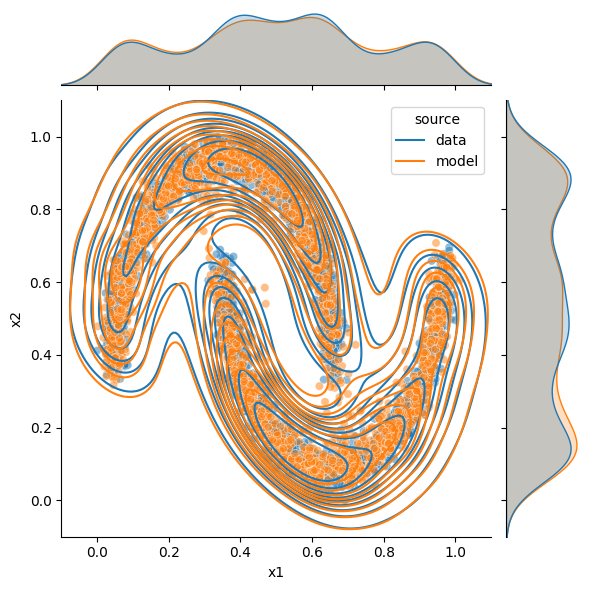

In [25]:
plot_samples(made_mctm, data, seed=3)

In [26]:
def get_bijector_fn(network, thetas_constrain_fn, **kwds):
    def bijector_fn(x0, input_depth, **kwds):
        with tf.name_scope("bernstein_bjector"):
            pvector = network(x0)
            M = pvector.shape[-1]
            pvector = tf.reshape(pvector, (-1, input_depth, M))
            thetas = thetas_constrain_fn(pvector)

            return tfb.Invert(BernsteinBijectorLinearExtrapolate(thetas=thetas))

    return bijector_fn

In [27]:
def fit_real_nvp_mctm(
    data,
    dims,
    epochs,
    seed,
    learning_rate,
    coupling_layers,
    hidden_units,
    activation,
    distribution,
    M,
    **kwds
):
    set_seed(seed)

    opt = tf.optimizers.Adam(learning_rate)

    thetas_constrain_fn = get_thetas_constrain_fn(**kwds)

    trainable_variables = []
    bijectors = []
    for l in range(coupling_layers):
        network = get_param_net(hidden_units, M)
        trainable_variables += network.trainable_variables
        bijectors.append(
            tfb.RealNVP(
                num_masked=(dims // 2),
                bijector_fn=get_bijector_fn(network, thetas_constrain_fn),
            )
        )
        if coupling_layers % 2 != 0 and l == (coupling_layers - 1):
            print("uneven number of coupling layers -> skipping last permuataion")
        else:
            bijectors.append(tfb.Permute(permutation=[1, 0]))

    nvp = tfd.TransformedDistribution(
        distribution=distribution,
        bijector=tfb.Chain(bijectors),
    )

    print("Number of Parameters:", sum(map(tf.size, trainable_variables)).numpy())

    it = trange(epochs)
    for i in it:
        nll = lambda: -nvp.log_prob(data)
        opt.minimize(nll, var_list=trainable_variables)
        it.set_postfix(loss=nll().numpy().mean(), lr=get_lr(opt, i))

    return nll().numpy().mean(), nvp

In [32]:
nll, real_nvp_mctm = fit_real_nvp_mctm(
    data,
    dims=dims,
    epochs=500,
    seed=1,
    learning_rate=0.01,
    coupling_layers=2,
    hidden_units=[16, 16],
    activation="relu",
    M=50,
    low=-3,
    high=3,
    smooth_bounds=True,
    allow_flexible_bounds=True,
    fn=tf.math.softplus,
    # eps=1e-04,
    distribution=tfd.Sample(tfd.Normal(loc=0.0, scale=1.0), sample_shape=[2]),
)
results["realNVP + MCTM"] = nll

Number of Parameters: 2308


100%|██████████████████████████████████████████████████████████| 500/500 [01:56<00:00,  4.31it/s, loss=-1.33, lr=0.01]


sampling took 0.320631742477417 seconds.


/tmp/ipykernel_570/3433419466.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2, ignore_index=True)


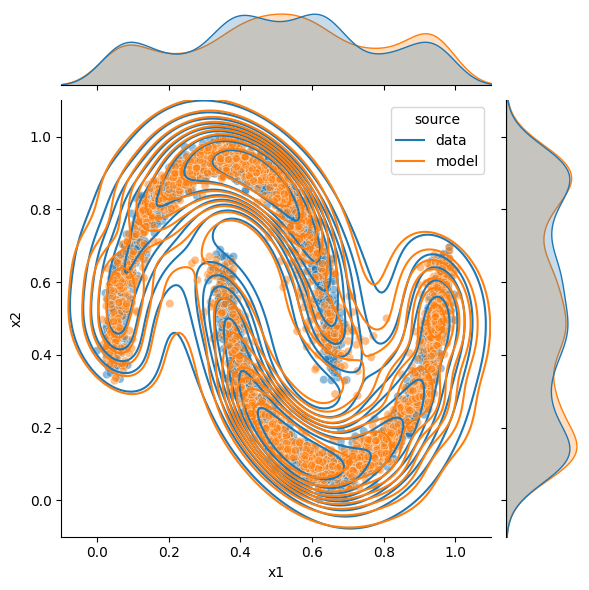

In [33]:
plot_samples(real_nvp_mctm, data, seed=3)

## MCTM as Base

### G. Papamakarios 2018: Masked Autoregressive Flow for Density Estimation

In [35]:
def get_lr_scheduler(warmup, steps, max_lr, min_lr, decay_rate):
    def scheduler(epoch):
        lr_warm = epoch / warmup * (max_lr - min_lr) + min_lr
        lr_cool = tf.exp(-decay_rate*(epoch - warmup) / (steps - warmup)) * (max_lr - min_lr) + min_lr
        return tf.where(epoch <= warmup, lr_warm, lr_cool)
    return scheduler

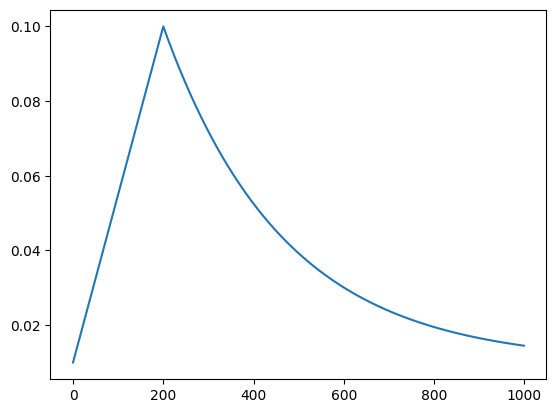

In [36]:
s=get_lr_scheduler(warmup=200, steps=1000, max_lr=0.1, min_lr=0.01, decay_rate=3)
plt.plot(s(np.arange(1000)))

In [37]:
class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, **kwds):
        self.s = get_lr_scheduler(**kwds)

    def __call__(self, step):
        return self.s(step)

In [40]:
nll, mctm_maf = fit_maf(
    data,
    dims=dims,
    epochs=1000,
    seed=1,
    learning_rate=MyLRSchedule(warmup=200, steps=1000, max_lr=0.01, min_lr=0.001, decay_rate=3),#0.001,
    hidden_units=[16, 16],
    layers=4,
    distribution=mctm,
)
results["MCTM base + MAF"] = nll

Number of Parameters: 1552


100%|█████████████████████████████████████████████████████| 1000/1000 [03:11<00:00,  5.21it/s, loss=-.761, lr=0.00145]


sampling took 0.14519667625427246 seconds.


/tmp/ipykernel_570/3433419466.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2, ignore_index=True)


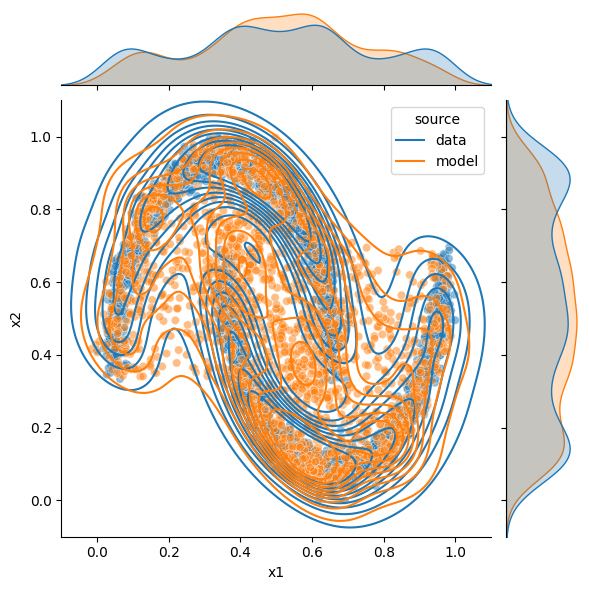

In [41]:
plot_samples(mctm_maf, data, seed=1)

### realNVP + BNF

In [ ]:
def get_param_net(hidden_layers, params):
    network = K.Sequential(
        [K.layers.Input((dims // 2))]
        + [K.layers.Dense(d, activation="relu") for d in hidden_layers]
        + [K.layers.Dense(params)]
    )

    return network

In [ ]:
def get_shift_and_log_scale_fn(hidden_layers):
    network = get_param_net(hidden_layers, 2)

    shift_and_log_scale_fn = lambda x, input_depth: tf.split(
        network(x), 2 * input_depth, axis=-1
    )
    return shift_and_log_scale_fn, network.trainable_variables

In [ ]:
def fit_real_nvp(
    data,
    dims,
    epochs,
    seed,
    learning_rate,
    coupling_layers,
    hidden_units,
    activation,
    distribution,
):
    set_seed(seed)

    opt = tf.optimizers.Adam(learning_rate)

    trainable_variables = []
    bijectors = []
    for _ in range(coupling_layers):
        shift_and_log_scale_fn, variables = get_shift_and_log_scale_fn(hidden_units)
        trainable_variables += variables
        bijectors.append(
            tfb.RealNVP(
                num_masked=(dims // 2), shift_and_log_scale_fn=shift_and_log_scale_fn
            )
        )
        bijectors.append(tfb.Permute(permutation=[1, 0]))

    deep_nvp = tfd.TransformedDistribution(
        distribution=distribution,
        bijector=tfb.Chain(bijectors),
    )

    print("Number of Parameters:", sum(map(tf.size, trainable_variables)).numpy())

    it = trange(epochs)
    for i in it:
        nll = lambda: -deep_nvp.log_prob(data)
        opt.minimize(nll, var_list=trainable_variables)
        it.set_postfix(loss=nll().numpy().mean(), lr=get_lr(opt, i))

    return nll().numpy().mean(), deep_nvp

In [42]:
nll, real_nvp_mctm2 = fit_real_nvp_mctm(
    data,
    dims=dims,
    epochs=2000,
    seed=1,
    learning_rate=0.01,
    #learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
  #initial_learning_rate=.1, decay_steps=2000, decay_rate=.01),
    #learning_rate=MyLRSchedule(warmup=200, steps=2000, max_lr=0.01, min_lr=0.001, decay_rate=0.5),#0.001,
    coupling_layers=1,
    hidden_units=[512, 512],
    activation="relu",
    M=100,
    low=0,
    high=1,
    smooth_bounds=True,
    allow_flexible_bounds=True,
    fn=tf.math.softplus,
    # eps=1e-04,
    distribution=mctm,
)
results["MCTM base + realNVP + MCTM"] = nll

uneven number of coupling layers -> skipping last permuataion
Number of Parameters: 314980


100%|████████████████████████████████████████████████████████| 2000/2000 [08:42<00:00,  3.83it/s, loss=-1.36, lr=0.01]


sampling took 0.2762913703918457 seconds.


/tmp/ipykernel_570/3433419466.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2, ignore_index=True)


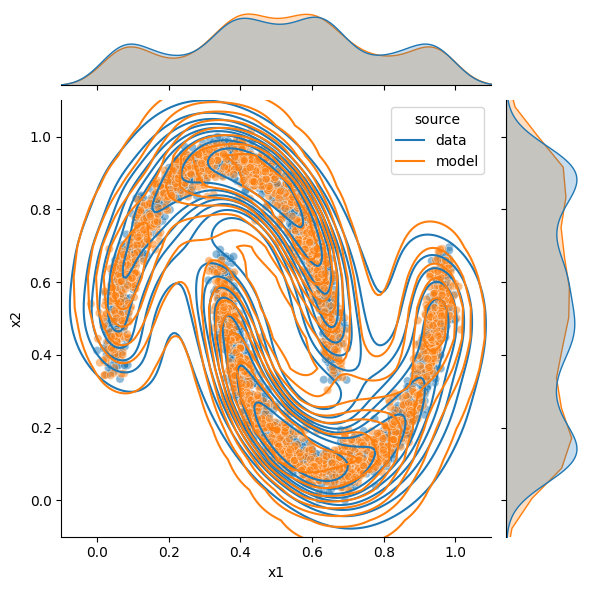

In [43]:
plot_samples(real_nvp_mctm2, data, seed=1)

In [44]:
def get_bijector_fn(network, thetas_constrain_fn, **kwds):
    def bijector_fn(x0, input_depth, **kwds):
        with tf.name_scope("bernstein_bjector"):
            pvector = network(x0)
            M = pvector.shape[-1]
            pvector = tf.reshape(pvector, (-1, input_depth, M))
            thetas = thetas_constrain_fn(pvector)

            return tfb.Invert(BernsteinBijectorLinearExtrapolate(thetas=thetas))

    return bijector_fn

In [45]:
def fit_real_nvp_mctm_simple(
    data,
    dims,
    epochs,
    seed,
    learning_rate,
    hidden_units,
    activation,
    distribution,
    M,
    **kwds
):
    set_seed(seed)

    opt = tf.optimizers.Adam(learning_rate)

    thetas_constrain_fn = get_thetas_constrain_fn(**kwds)

    network = get_param_net(hidden_units, M)
    network.build((dims,))
    trainable_variables =network.trainable_variables
    bijector=tfb.RealNVP(
        num_masked=(1),
        bijector_fn=get_bijector_fn(network, thetas_constrain_fn),
    )

    nvp = tfd.TransformedDistribution(
        distribution=distribution,
        bijector=bijector,
    )

    print("Number of Parameters:", sum(map(tf.size, trainable_variables)).numpy())

    it = trange(epochs)
    for i in it:
        nll = lambda: -nvp.log_prob(data)
        opt.minimize(nll, var_list=trainable_variables)
        it.set_postfix(loss=nll().numpy().mean(), lr=get_lr(opt, i))

    return nll().numpy().mean(), nvp

In [46]:
nll, real_nvp_mctm_simple = fit_real_nvp_mctm_simple(
    data,
    dims=dims,
    epochs=2000,
    seed=1,
    learning_rate=0.01,
    #learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
  #initial_learning_rate=.1, decay_steps=2000, decay_rate=.01),
    #learning_rate=MyLRSchedule(warmup=200, steps=2000, max_lr=0.01, min_lr=0.001, decay_rate=0.5),#0.001,
    hidden_units=[64, 64],
    activation="relu",
    M=100,
    low=0,
    high=1,
    smooth_bounds=True,
    allow_flexible_bounds=True,
    fn=tf.math.softplus,
    # eps=1e-04,
    distribution=mctm,
)
results["MCTM base + realNVP (simple) + MCTM"] = nll

Number of Parameters: 10788


100%|████████████████████████████████████████████████████████| 2000/2000 [06:58<00:00,  4.78it/s, loss=-1.29, lr=0.01]


sampling took 0.26558423042297363 seconds.


/tmp/ipykernel_570/3433419466.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2, ignore_index=True)


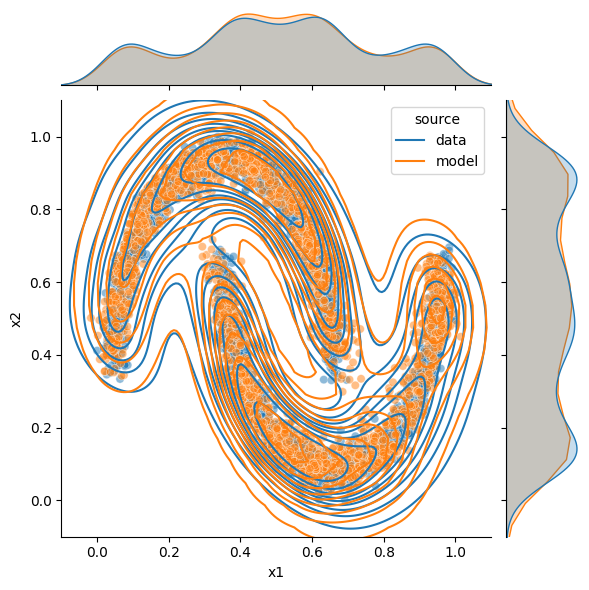

In [47]:
plot_samples(real_nvp_mctm_simple, data, seed=1)

# Results

In [77]:
df = pd.DataFrame.from_dict(results, orient="index")
df.columns = ["NLL"]
df